In [5]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from statistics import mean, stdev
from math import sqrt
from neuroCombat import neuroCombat

sns.set_theme(context="talk")
pal = sns.color_palette()

### functions 

In [6]:
def remove_outlier(df, index):
    Q1 = df[index].quantile(0.25)
    Q3 = df[index].quantile(0.75)

    IQR = Q3 - Q1

    filter = (df[index] >= Q1 - 1.5*IQR) &  (df[index] <= Q3 + 1.5*IQR)
    outlier =  (df[index] <= Q1 - 1.5*IQR) |  (df[index] >= Q3 + 1.5*IQR)

    return df.loc[filter], df.loc[outlier]

def clean_dataframe(df, index):
  df = df.rename(columns={"Modele": "Model"})

  df = df[(df != 0).all(1)]
  df = df.dropna()

  df_inliers, df_outlier = remove_outlier(df, index)


  return df_inliers, df_outlier

def cohens_d(c0, c1):
  std_diff = sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2)
  return (mean(c0) - mean(c1)) / std_diff

In [7]:
filedir = '/home/local/VANDERBILT/dolel/Documents/rsHRF_project/output/WM_GM_analysis/csv_all_infos/meanbrain_'
params = ['Height', 'DipHeight', 'TroughHeight', 'PeakIntegral', 'DipIntegral','TroughIntegral', 'Time2peak', 'Time2dip', 'Time2trough',  'FWHM']
manufacturer = ['GE', 'Philips', 'Siemens']

### 1. cohen's d - effect size across features

In [8]:
nb_manu = len(manufacturer)
nb_features = len(params) 

mat_d = np.zeros(shape=(nb_manu, nb_features))
combination = [ (0,1), (0,2),(1,2)]

y_axis_name = []
tissu = 'GM'


Text(145.5, 0.5, 'scanner effect studied')

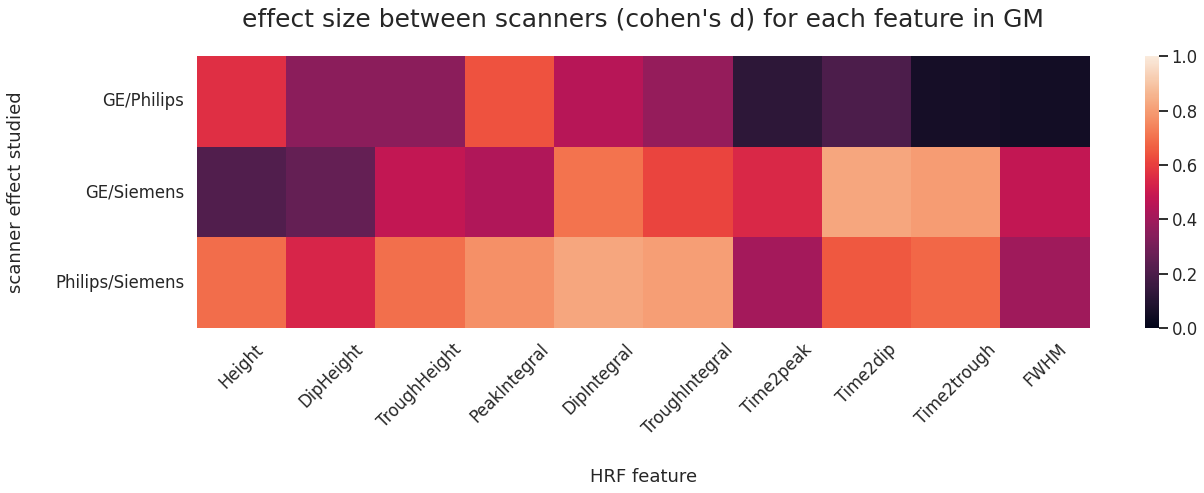

In [9]:
for i in range(nb_features):
  feature = params[i]
  file = filedir + feature + '.csv'
  df = pd.read_csv(file)

  for j in range(nb_manu):
    scan_1 = manufacturer[combination[j][0]]
    scan_2 = manufacturer[combination[j][1]]

    df_1 = df.loc[df['Manufacturer']== scan_1]
    df_2 = df.loc[df['Manufacturer']== scan_2]

    name_d = scan_1 + "/" + scan_2
    y_axis_name.append(name_d)

    mat_d[j,i] = abs(cohens_d(df_1[tissu], df_2[tissu]))


y_axis_name = y_axis_name[0:nb_manu]
df_d = pd.DataFrame(data=mat_d)


ax = plt.figure(figsize=(20,5))

cmap = sns.color_palette("vlag", as_cmap=True)
ax = sns.heatmap(df_d, vmin=0, vmax=1)

plt.xticks(np.arange(nb_features)+0.5, params, rotation=45)
plt.yticks(np.arange(nb_manu)+0.5, y_axis_name, rotation=0)

plt.title("effect size between scanners (cohen's d) for each feature in {:}".format(tissu), fontsize=25,pad=30)
plt.xlabel("HRF feature",labelpad=30)
plt.ylabel("scanner effect studied",labelpad=30)

In [10]:
def hue_regplot(data, x, y, hue, palette=None, legend=False, **kwargs):
    
    regplots = []
    
    levels = data[hue].unique()
    pal = sns.color_palette("husl", n_colors=len(levels))
    
    i = 0
    if legend:
        for key in levels:
            regplots.append(sns.regplot(x=x, y=y, data=data[data[hue] == key], color=pal[i], label= key))
            i +=1
            plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left")

    else:
        for key in levels:
            regplots.append(sns.regplot(x=x, y=y, data=data[data[hue] == key], color=pal[i]))
            i +=1

    return regplots


### 2. TR/scanner distribution

In [603]:
df = pd.read_csv(filedir + 'Time2peak.csv')
df = df.loc[ df['WM']> 4]
df = df.rename(columns={'Modele':'Model'})
df,_  = clean_dataframe(df, 'WM', 'all')

In [604]:
## list of scanners to study and remove based on the number of scans avalaible by machine --> c.f. df['Modele'].value_counts()

scans_to_remove = ['Biograph_mMR', 'Skyra_fit', 'SIGNA_Premier', 'Ingenia_Elition_X', 'Achieva_dStream', 'Ingenuity', 'Signa_HDxt']
scans_to_keep = ['Achieva', 'Intera', 'DISCOVERY_MR750', 'Prisma_fit', 'Ingenia', 'Prisma', 'TrioTim', 'Skyra', 'Verio', 'GEMINI', 'DISCOVERY_MR750w']

df_clean = df.loc[ df.Model.isin(scans_to_keep)]
# df_clean
effect_studied = 'Model'
list_params_studied = ["GM", "WM", 'Sex', 'Weight']

In [676]:
def applyComBAT(df, list_tissus,  list_params_studied, effect_studied,exp_name):

    ## prepare data in the good format
    dfdata = df[ list_tissus ]
    dfdata = dfdata.transpose()

    filename = '../../../rsHRF_project/test.csv'
    dfdata.to_csv(filename, index=False)
    dfdata = pd.read_csv(filename)

    data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    data = data[0: len(list_tissus),:] #take only the tissus specified

    ## prepare batch dataframe
    keys = np.unique(df[effect_studied].to_numpy())
    values = np.arange(len(keys))
    dic_scan = {keys[i]: values[i] for i in range(len(keys))}

    batch = df.copy()
    for k in keys:
        batch.loc[batch[effect_studied] == k, effect_studied] = dic_scan[k]
        
    batch = batch[effect_studied]
    batch = pd.DataFrame({'batch':batch.to_numpy()})  
    print(dic_scan)
    covars = batch
    categorical_cols = []
    ## other covariates
    for param in list_params_studied:
        # categorical & char variables -> change in binary
        if param =='Sex':
            gender = df.copy()
            gender.loc[gender["Sex"] == "F", "Sex"] = 1
            gender.loc[gender["Sex"] == "M", "Sex"] = 2
            
            covars['Sex'] = gender["Sex"].to_numpy() 
            categorical_cols = ['Sex']

        else:
            covars[param] = df[param].to_numpy() 

    # # # Harmonization step:
    batch_col = 'batch'
    dict_combat = neuroCombat(dat=data,
        covars=covars,
        batch_col=batch,
        categorical_cols=categorical_cols)

    data_combat = dict_combat["data"]

    df_out = df.copy()

    for i in range(len(list_tissus)):
        df_out[ list_tissus[i] + '_' + exp_name] = data_combat[i,:]
    
    return df_out, dict_combat

### ComBAT  2 step: TR then Model

In [11]:
scans_to_remove = ['Biograph_mMR', 'Skyra_fit', 'SIGNA_Premier', 'Ingenia_Elition_X', 'Achieva_dStream', 'Ingenuity', 'Signa_HDxt']
scans_to_keep = ['Achieva', 'Intera', 'DISCOVERY_MR750', 'Prisma_fit', 'Ingenia', 'Prisma', 'TrioTim', 'Skyra', 'Verio', 'GEMINI', 'DISCOVERY_MR750w']

feature = 'FWHM'
path = filedir + feature +'.csv'
print(path)
df = pd.read_csv(filedir + feature +'.csv')
effect_studied = ['TR', 'Model']

TR_to_keep = [0.607, 3.025, 3]

/home/local/VANDERBILT/dolel/Documents/rsHRF_project/output/WM_GM_analysis/csv_all_infos/meanbrain_FWHM.csv


In [12]:
# df_clean = pd.DataFrame()
# for i in TR_to_keep:

#     df_1 = df.loc[ df['TR'] == i]
#     df_1["Mean_Brain"] = df_1[["GM", "WM"]].mean(axis=1)
#     df_1, _ = clean_dataframe(df_1, 'Mean_Brain')

#     df_clean = pd.concat([df_clean, df_1])

1. TR harmonization

In [14]:
### remove scanner with samples < 24
df = df.loc[ df.Modele.isin(scans_to_keep)]

### split in 2 cases TR = 0.607 and TR ~= 3 (= samples > 19)
df_1 = df.loc[ df['TR'] == 0.607]
df_1["Mean_Brain"] = df_1[["GM", "WM"]].mean(axis=1)
df_1, _ = clean_dataframe(df_1, 'Mean_Brain')

df_2 = df.loc[ (df['TR'] == 3.025) | (df['TR'] == 3) ]
df_2["Mean_Brain"] = df_2[["GM", "WM"]].mean(axis=1)
df_2, _ = clean_dataframe(df_2, 'Mean_Brain')

df_clean = pd.concat([df_1, df_2])

# df_TR, dict_combat =  applyComBAT(df_clean, ['GM', 'WM'], [], effect_studied[0],'TR_Harmonization')
# df_tmp = df_TR.copy()
# df_Model, dict_combat =  applyComBAT(df_2, ['GM', 'WM'], [], effect_studied[1],'harmonization_Model_TR_3')

/tmp/ipykernel_2720599/3211638103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["Mean_Brain"] = df_1[["GM", "WM"]].mean(axis=1)
/tmp/ipykernel_2720599/3211638103.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["Mean_Brain"] = df_2[["GM", "WM"]].mean(axis=1)


In [46]:
## prepare data in the good format
dfdata = df_clean[ ["GM", "WM"] ]
dfdata = dfdata.transpose()

filename = '../../../rsHRF_project/test.csv'
dfdata.to_csv(filename, index=False)
dfdata = pd.read_csv(filename)

data = np.genfromtxt(filename, delimiter=',', skip_header=1)
data = data[0:2,:] #take only the tissus specified


### secondbatch
keys = np.unique(df_clean['Model'].to_numpy())
values = np.arange(len(keys))
dic_scan = {keys[i]: values[i] for i in range(len(keys))}

model = df_clean.copy()
dftr= df_clean.copy()
i = 0
for k in keys:
    j = 0
    for tr in np.unique(df_clean['TR'].to_numpy()):
        model.loc[ (model['Model'] == k) & (model['TR']==tr), 'Model'] = i
        dftr.loc [dftr['TR']==tr, 'TR'] = j
        i +=1
        j += 1

# np.unique(model['Model'].to_numpy())
# np.unique(dftr['TR'].to_numpy())

## prepare batch dataframe
# keys = np.unique(df_clean['TR'].to_numpy())
# values = np.arange(len(keys))
# dic_scan = {keys[i]: values[i] for i in range(len(keys))}

# tr = df_clean.copy()
# for tr in [0.607, 3.025]:
#     model.loc[model['TR'] == k, 'Model'] = dic_scan[k]


# tr = tr['TR']
model = model['Model']

model.value_counts()

batch = pd.DataFrame({'model':model.to_numpy()}) 
covars = batch


batch_col = ['model']
dict_combat = neuroCombat(dat=data,
    covars=covars,
    batch_col=batch_col)

data_combat = dict_combat["data"]

df_out = df_clean.copy()

list_tissus=['GM', 'WM']
for i in range(2):
    df_out[ list_tissus[i] + '_harmonized_TR_Model'] = data_combat[i,:]
    

1     321
4     177
22    147
13     94
21     74
16     65
18     62
19     58
28     39
25     31
31     28
10     27
7      22
17     19
Name: Model, dtype: int64


[55, 97, 5.11725, 8.63367]


Text(0.5, 0.98, 'Harmonization of scanner effects with 2 level ComBAT on FWHM')

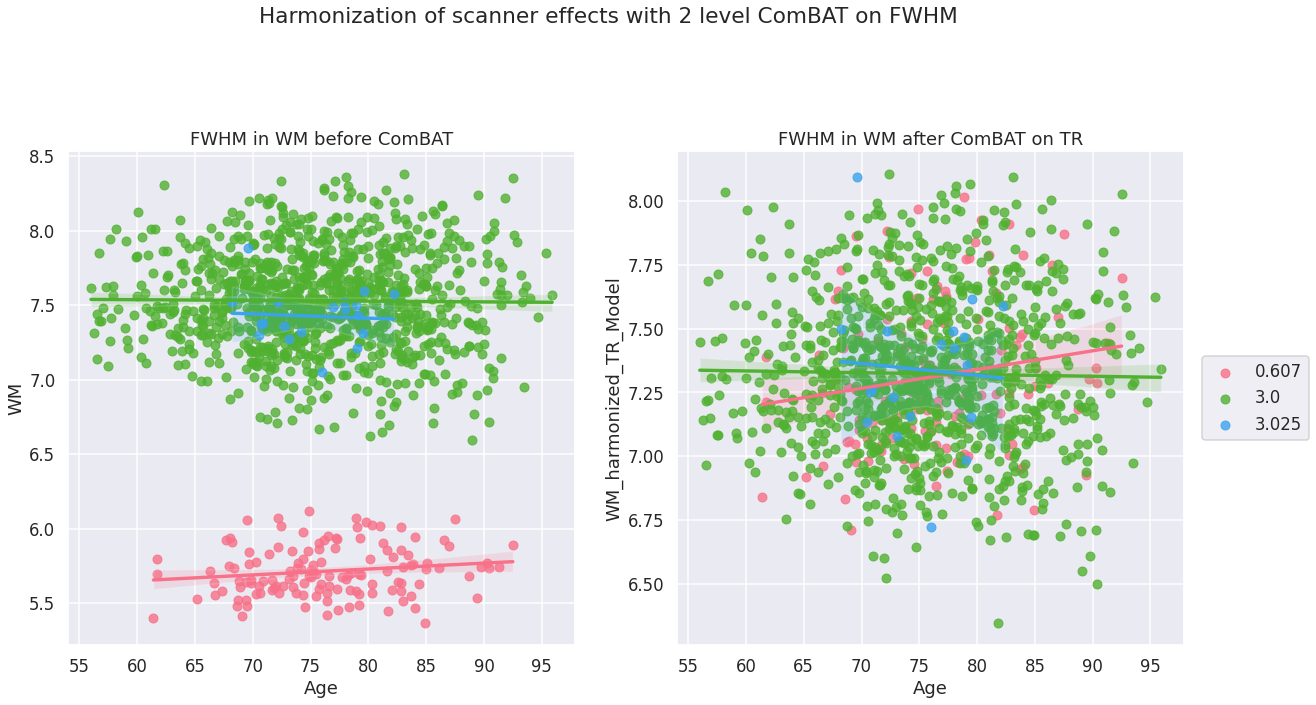

In [44]:
# regplot has arguments for covariates to regress
xmin = int(np.min(df_out['Age'])) -1
xmax = round(np.max(df_out['Age'])) +1

ymin_1 = min(np.min(df_out['WM']), np.min(df_out['WM_harmonized_TR_Model'])) -0.25
ymax_1 = max(np.max(df_out['WM']), np.max(df_out['WM_harmonized_TR_Model'])) + 0.25

# ymin_2 = min(np.min(df_out['WM_TR_Harmonization']), np.min(df_out['WM_TR_Harmonization_and_Model'])) -0.05
# ymax_2 = max(np.max(df_out['WM_TR_Harmonization']), np.max(df_out['WM_TR_Harmonization_and_Model'])) + 0.05

axis = [xmin, xmax, ymin_1, ymax_1] 
print( axis)

plt.figure(figsize=(20,20))
ax = plt.subplot(221)
plot_hue = hue_regplot(data=df_clean, x='Age', y='WM', hue=effect_studied[0])
plt.title("{:} in {:} before ComBAT".format(feature, 'WM'))
# plt.axis(axis)

plt.subplot(222)
plot_hue = hue_regplot(data=df_out, x='Age', y='WM_harmonized_TR_Model', hue=effect_studied[0], legend=True)
plt.title("{:} in {:} after ComBAT on {}".format(feature, 'WM', 'TR'))
# plt.axis(axis)

# axis = [xmin, xmax, ymin_2, ymax_2]
# print((axis))
# ax = plt.subplot(223)
# plot_hue = hue_regplot(data=df_TR, x='Age', y='GM_TR_Harmonization', hue=effect_studied[1])
# plt.title("{:} in {:} after ComBAT on {:}".format(feature, 'GM', effect_studied[0]))
# # plt.axis(axis)

# plt.subplot(224)
# plot_hue = hue_regplot(data=df_Model, x='Age', y='GM_TR_Harmonization_and_Model', hue=effect_studied[1], legend=True)
# plt.title("{:} in {:} after ComBAT on {} and {}".format(feature, 'GM', effect_studied[0], effect_studied[1]))
# plt.axis(axis)

plt.suptitle("Harmonization of scanner effects with 2 level ComBAT on {}".format(feature))

In [924]:
from scipy import stats

Text(0, 0.5, 'PeakIntegral')

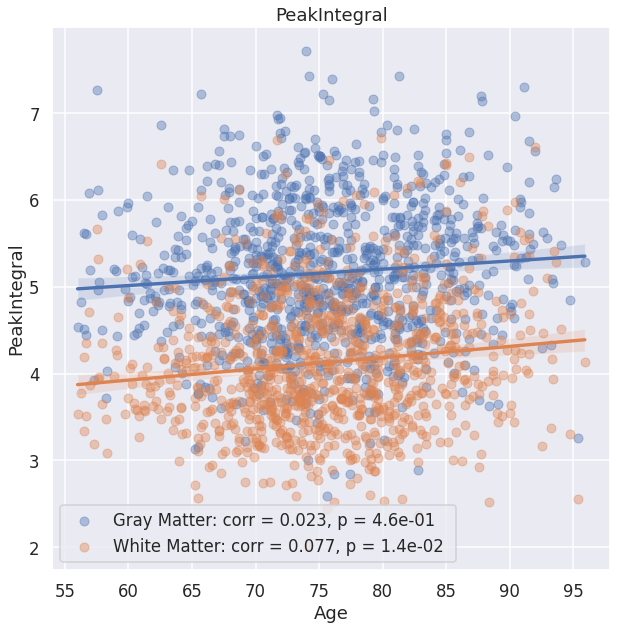

In [925]:
plt.figure(figsize=(10,10))
r_gm, p_gm = np.round(stats.pearsonr(df_Model['Age'], df_Model['GM_and_Model']), decimals=5)
r_wm, p_wm = np.round(stats.pearsonr(df_Model['Age'], df_Model['WM_and_Model']), decimals=5)

legend_gm = "Gray Matter: corr = {:.3f}, p = {:.1e} ".format(r_gm, p_gm)
legend_wm = "White Matter: corr = {:.3f}, p = {:.1e} ".format(r_wm, p_wm)

sns.regplot(x='Age', y='GM', data=df_Model,  scatter_kws={'alpha':0.4}, label=legend_gm)
sns.regplot(x='Age', y='WM', data=df_Model,  scatter_kws={'alpha':0.4}, label=legend_wm)

plt.legend()
plt.xlabel('Age')
plt.title(feature)
plt.ylabel(feature)
